In [1]:
import sys
# sys.path.append("../..")
# sys.path.insert(1, 'C:/Users/isrqa/ELIopt-main/ELIopt-main/algorithms')
from bayes_opt import BayesianOptimization
from L1_DifferentialEvolution import extract_data, model, diff_evolution
from NelderMead import bounded_nelder_mead
import math
import physics
from losses import Losses
from scipy.optimize import Bounds
from scipy.optimize import minimize
from pyswarm import pso
import numpy as np
import matplotlib.pyplot as plt

In [2]:
frequency, intensity = extract_data() # extracting the desired information

# compressor parameters - obtained as minus the stretcher one - TO BE FIXED WITH REAL ONES ONCE THEY ARE AVAILABLE
COMPRESSOR = -1 * np.array((267.422 * 1e-24, -2.384 * 1e-36, 9.54893 * 1e-50)) # in s^2, s^3 and s^4 (SI units)
# non linearity parameter
B = 2
# cutoff frequencies, in THz, used to remove noise - derived from visual inspection
CUTOFF = (289.95, 291.91)
# model instantiation
l1_pump = model(frequency, intensity, COMPRESSOR, B, CUTOFF, num_points=int(5e3))

losses = Losses(l1_pump)

bounds_DE = Bounds(
            # GDD         # TOD          # FOD
    lb = (2.3522e-22, -1.003635e-34, 4.774465e-50),
    ub = (2.99624e-22, 9.55955e-35, 1.4323395e-49)
)

bounds_matrix = np.vstack((bounds_DE.lb, bounds_DE.ub)).T
disp_bounds = np.sort(l1_pump.translate_control(bounds_matrix, verse = "to_disp"))

In [3]:
def outer_objfunc(mutation:float, cross_p:float, population_size:float) -> float: 
    """
    This is the outher objective function which is taking as input values characteristic of the 
    optimisation process.
    For further documentantion on the relevance of these parameters and their effect on the optimisation 
    route check literature.
    """
    population_size = int(population_size) # must be int
    
    candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = population_size,
        verbose = 0, 
        maxit = 500, 
        print_every = 50
    )
    
    return -1 * losses.loss3(candidate_best) # maximizing

In [16]:
params_bounds = {
    "mutation": (0.5, 1.99), 
    "cross_p": (0, 1), 
    "population_size": (10, 50)
}

optimizer = BayesianOptimization(
    f = outer_objfunc, 
    pbounds = params_bounds, 
    random_state = 10, 
    verbose = 1
)

n_init, n_iter = 50, 50
optimizer.maximize(init_points = n_init, n_iter = n_iter)
print(optimizer.max["params"].values())
# dict_values([0.6903393772628603, 1.3025469798237372, 35.55385997830314])

|   iter    |  target   |  cross_p  | mutation  | popula... |
-------------------------------------------------------------
 Iterations = 17500
 Iterations = 9000
 Iterations = 8000
 Iterations = 24000
 Iterations = 21000
 Iterations = 10500
 Iterations = 15500
 Iterations = 18000
 Iterations = 17000
 Iterations = 17000
 Iterations = 23000
 Iterations = 11000
 Iterations = 5500
 Iterations = 21000
 Iterations = 12000
 Iterations = 22500
|  16       | -1.443    |  0.7546   |  0.941    |  45.36    |
 Iterations = 12500
 Iterations = 8000
 Iterations = 24500
 Iterations = 10000
 Iterations = 15500
 Iterations = 12000
|  22       | -1.443    |  0.5902   |  0.5585   |  24.29    |
 Iterations = 11500
 Iterations = 13500
 Iterations = 11500
 Iterations = 20000
 Iterations = 17000
 Iterations = 10000
|  28       | -1.443    |  0.5135   |  1.391    |  20.49    |
 Iterations = 11000
 Iterations = 16000
 Iterations = 6000
 Iterations = 14500
 Iterations = 11000
 Iterations = 22000
 Iterations = 2

In [4]:
# cross_p, mutation, pop_size = optimizer.max["params"].values()
cross_p = 0.622245891254157
mutation = 1.9301295865991803
pop_size = 21.46001053968225
# cross_p, mutation, pop_size = optimizer.max["params"].values()
# training with the best parameters and increased number of iterations
candidate_best = diff_evolution(
        objective_function = losses.loss3,
        bounds = disp_bounds,
        mutation = mutation, 
        cross_p = cross_p, 
        population_size = int(pop_size),
        verbose = 1, 
        maxit = 120, 
        print_every = 1
)
print(losses.loss3(candidate_best))
print(candidate_best)

Iteration 0 - Objective Function value: 32.48784209272344
Iteration 1 - Objective Function value: 32.48784209272344
Iteration 2 - Objective Function value: 32.48784209272344
Iteration 3 - Objective Function value: 32.48784209272344
Iteration 4 - Objective Function value: 32.48784209272344
Iteration 5 - Objective Function value: 32.48784209272344
Iteration 6 - Objective Function value: 32.48784209272344
Iteration 7 - Objective Function value: 32.48784209272344
Iteration 8 - Objective Function value: 19.79558036313815
Iteration 9 - Objective Function value: 19.79558036313815
Iteration 10 - Objective Function value: 19.79558036313815
Iteration 11 - Objective Function value: 19.79558036313815
Iteration 12 - Objective Function value: 19.79558036313815
Iteration 13 - Objective Function value: 19.79558036313815
Iteration 14 - Objective Function value: 19.79558036313815
Iteration 15 - Objective Function value: 19.79558036313815
Iteration 16 - Objective Function value: 19.79558036313815
Iterati

In [36]:
def outer_objfunction(alpha:float, gamma:float, rho:float, sigma:float) -> float: 
#     def outer_objfunc(mutation:float, cross_p:float, population_size:float) -> float: 
    """
    This is the outher objective function which is taking as input values characteristic of the 
    optimisation process.
    For further documentantion on the relevance of these parameters and their effect on the optimisation 
    route check literature.
    """
#     population_size = int(population_size) # must be int
    print_NM_progress = 0
    random_values = [np.random.uniform(low=low, high=high) for low, high in bounds]
    
    res = bounded_nelder_mead(losses.loss3, random_values, disp_bounds, print_NM_progress, maxiter=100, alpha=alpha, gamma=gamma, rho=rho, sigma=sigma, tol=1e-4)
    
#     candidate_best = diff_evolution(
#         objective_function = losses.loss3,
#         bounds = disp_bounds,
#         mutation = mutation, 
#         cross_p = cross_p, 
#         population_size = population_size,
#         verbose = 0, 
#         maxit = 500, 
#         print_every = 50
#     )
    
    return -1 * losses.loss3(res.x) # maximizing

In [37]:
params_bounds = {
    "alpha": (0.5, 1.5), 
    "gamma": (1.1, 2.5), 
    "rho": (0.1, 0.7),
    "sigma": (0.3, 0.9)
}

optimizer_NM = BayesianOptimization(
    f = outer_objfunction, 
    pbounds = params_bounds, 
    random_state = 10, 
    verbose = 1
)

n_init, n_iter = 100, 100
optimizer_NM.maximize(init_points = n_init, n_iter = n_iter)
print(optimizer_NM.max["params"].values())

|   iter    |  target   |   alpha   |   gamma   |    rho    |   sigma   |
-------------------------------------------------------------------------


TypeError: tuple indices must be integers or slices, not tuple

In [7]:
print_NM_progress = 1
# alpha, gamma, rho, sigma = optimizer.max["params"].values()

# Define the initial position and bounds
bounds=((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15))

# Run the optimization using Nelder-Mead method
res = bounded_nelder_mead(losses.loss3, candidate_best, disp_bounds, print_NM_progress)

# Print the results
print(res.x)
print(res.fun)
print(res.message)
print('iterations:', res.nit)
print('function evaluations:', res.nfev)

iteration: 1
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 2
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 3
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 4
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 5
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 6
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 7
best value of objective function so far: 1.9253287057621282
best candidate: [-4.75308273e-01 -6.52444391e+06  1.56859005e+15]
iteration: 8
best value of 

In [8]:
candidate_best

array([-4.75308273e-01, -6.52444391e+06,  1.56859005e+15])

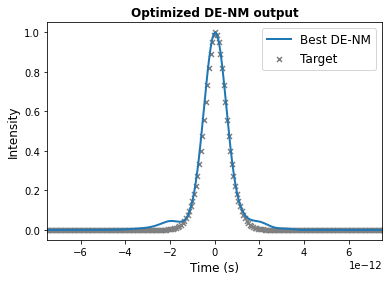

In [9]:
# candidate_best = solution
# time, profile = l1_pump.forward_pass(candidate_best)
time, profile = l1_pump.forward_pass(res.x)
fig, ax = plt.subplots()

ax.set_title("Optimized DE-NM output", fontweight = "bold")
ax.scatter(losses.target_time, losses.target_profile, marker = "x", c = "grey", s = 25, label = "Target")
ax.plot(losses.target_time, np.roll(profile, - np.argmax(profile) + np.argmax(losses.target_profile)), label = "Best DE-NM", lw = 2)

ax.set_xlim(-7.5e-12, 7.5e-12); ax.set_xlabel("Time (s)", fontsize = 12); ax.set_ylabel("Intensity", fontsize = 12)
ax.legend(fontsize = 12)
plt.show()

In [24]:
import numpy as np

# Define the bounds
disp_bounds = ((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15))
bounds = np.array(((-5.31305788e-01, -4.17101926e-01), (-3.14772231e+08, 3.01620182e+08), (-2.55151879e+15, 1.56859005e+15)))

# Set the number of iterations
num_iterations = 100

# Initialize lists to store the minimum function values for each run
min_fun_values = []
fevaluations = []

# Run the optimization multiple times
for i in range(num_iterations):
    # Set the values for cross_p, mutation, and pop_size
    cross_p = 0.6903393772628603
    mutation = 1.3025469798237372
    pop_size = 35
#     dict_values([0.6903393772628603, 1.3025469798237372, 35.55385997830314])
    # Run differential evolution optimization with the given parameters
    candidate_best = diff_evolution(
        objective_function=losses.loss3,
        bounds=disp_bounds,
        mutation=mutation,
        cross_p=cross_p,
        population_size=int(pop_size),
        verbose=0,
        maxit=45
    )
#     candidate_best
    # Set the parameters for the Nelder-Mead method
#     alpha, gamma, rho, sigma = optimizer.max["params"].values()
    print_NM_progress = 0
    # Run the optimization using Nelder-Mead method
    res = bounded_nelder_mead(
        losses.loss3,
        candidate_best,
        bounds,
        print_NM_progress
    )

    # Store the minimum function value for each run
    min_fun_values.append(res.fun)
    fevaluations.append(res.nfev)

    # Print the minimum function value for each run
    print(f"Run {i+1} - Minimum function value: {res.fun}")

# Calculate the mean and minimum of the minimum function values
mean_min_fun = np.mean(min_fun_values)
min_min_fun = np.min(min_fun_values)

# Calculate the average minimum function value
average_fev = np.mean(fevaluations) + 1575

# Print the mean and minimum of the minimum function values
print("Mean of minimum function values:", mean_min_fun)
print("Minimum of minimum function values:", min_min_fun)
print("Average number of function evaluations:", average_fev)

 Iterations = 1575
Run 1 - Minimum function value: 1.443307639183337
 Iterations = 1575
Run 2 - Minimum function value: 1.443305384291023
 Iterations = 1575
Run 3 - Minimum function value: 1.4437689789609793
 Iterations = 1575
Run 4 - Minimum function value: 1.4656628259699003
 Iterations = 1575
Run 5 - Minimum function value: 1.9288027634017924
 Iterations = 1575
Run 6 - Minimum function value: 1.4434070806727584
 Iterations = 1575
Run 7 - Minimum function value: 1.4433238026901598
 Iterations = 1575
Run 8 - Minimum function value: 1.4433113746291202
 Iterations = 1575
Run 9 - Minimum function value: 2.121127016331474
 Iterations = 1575
Run 10 - Minimum function value: 1.4433435179454153
 Iterations = 1575
Run 11 - Minimum function value: 2.103188936512802
 Iterations = 1575
Run 12 - Minimum function value: 1.4433226565765735
 Iterations = 1575
Run 13 - Minimum function value: 1.443336511723897
 Iterations = 1575
Run 14 - Minimum function value: 1.443355863338343
 Iterations = 1575
Ru

In [23]:
np.mean(fevaluations)+1575

1673.2